In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['HF_HOME'] = '/data/zhujinguo/hf_home'
os.environ['HF_DATASETS_CACHE'] = '/data/zhujinguo/hf_home'
import torch

/home/lechatelia/anaconda3/envs/zjg/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lechatelia/anaconda3/envs/zjg/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id = "google/ddpm-cifar10-32"
# model_id = "google/ddpm-cat-256"
model_id = '/data/zhujinguo/diffusers/ddpm-butterflies-128'

In [3]:
from diffusers import DDPMPipeline


# load model and scheduler
ddpmpipeline = DDPMPipeline.from_pretrained(model_id).to('cuda')

Setting ds_accelerator to cuda (auto detect)


In [7]:
ddpmpipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.utils.dummy_torch_and_scipy_objects.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscre

100%|██████████| 1000/1000 [00:34<00:00, 28.98it/s]


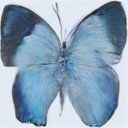

In [19]:
generator = torch.Generator(device="cuda").manual_seed(0)
image = ddpmpipeline(1, generator=generator).images[0]
image 

In [12]:
ddpmpipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.17.0.dev0')])

In [9]:
ddpmpipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.17.0.dev0')])

# DDIM
下面主要是想替换成ddim的scheduler，但是如果按照官方的教程https://huggingface.co/docs/diffusers/using-diffusers/schedulers 是可以复用pipeline的，但是由于官网ddpm的pipeline是没办法传入一些参数给ddim的scheduler的（比如num_inference_steps，eta，），所以我这边也重新弄了ddim的pipeline，然后传入ddpm的unet，确保一些ddim的参数能够被合理传入。

In [17]:
from diffusers import DDIMPipeline
from diffusers import DDIMScheduler
ddim_scheduler = DDIMScheduler.from_config( ddpmpipeline.scheduler.config)

ddim_pipeline = DDIMPipeline(ddpmpipeline.unet, ddim_scheduler)


100%|██████████| 10/10 [00:00<00:00, 24.14it/s]


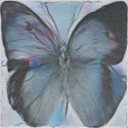

In [18]:
generator = torch.Generator(device="cuda").manual_seed(0)
image = ddim_pipeline(1, generator=generator, num_inference_steps=10,
        eta=0.0,
        use_clipped_model_output=True).images[0]
image 

100%|██████████| 50/50 [00:01<00:00, 29.34it/s]


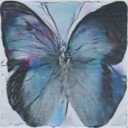

In [20]:
generator = torch.Generator(device="cuda").manual_seed(0)
image = ddim_pipeline(1, generator=generator, num_inference_steps=50,
        eta=0.0,
        use_clipped_model_output=True).images[0]
image 

# DPMSolverSinglestepScheduler

schduler不需要传入 generator 所以 pipeline仍然无法复用，但是可以复用 unet

当然我这里就直接改了forward 函数 让其能够直接用一个pipeline
```python
 step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        return_dict: bool = True,
        **kwargs, ## 加入多余参数
        ```
```
        



In [10]:
from diffusers import DPMSolverSinglestepScheduler

# 也可以在这里加入其他的参数 for scheduler 
dpm_scheduler = DPMSolverSinglestepScheduler.from_config(
    ddpmpipeline.scheduler.config, solver_order=3)


100%|██████████| 50/50 [00:02<00:00, 23.17it/s]


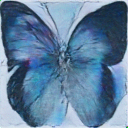

In [11]:
ddpmpipeline.scheduler = dpm_scheduler
generator = torch.Generator(device="cuda").manual_seed(0)
image = ddpmpipeline(1, generator=generator, num_inference_steps=50).images[0]
image


In [9]:
dpm_scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('solver_order', 3),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('algorithm_type', 'dpmsolver++'),
            ('solver_type', 'midpoint'),
            ('lower_order_final', True),
            ('use_karras_sigmas', False),
            ('lambda_min_clipped', -inf),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('clip_sample_range', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.17.0.dev0')])

# scheduling_dpmsolver_multistep 


In [13]:
from diffusers import DPMSolverMultistepScheduler

# 也可以在这里加入其他的参数 for scheduler 
dpm_scheduler = DPMSolverMultistepScheduler.from_config(
    ddpmpipeline.scheduler.config)


100%|██████████| 10/10 [00:00<00:00, 24.76it/s]


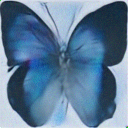

In [15]:
ddpmpipeline.scheduler = dpm_scheduler
generator = torch.Generator(device="cuda").manual_seed(0)
image = ddpmpipeline(1, generator=generator, num_inference_steps=10).images[0]
image
